In [1]:
import collections
import math
import re
import sys
import os
import requests
import json
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

In [2]:
sys.path.append(os.path.abspath('../'))
from personal import SESSION, LEADERBOARD_URL

In [3]:
data = json.loads(requests.get(
    LEADERBOARD_URL,
    cookies = {'session': SESSION},
).text)

In [4]:
df = pd.DataFrame(data['members']).T.sort_values(by='local_score', ascending=False)
df['name'].replace(np.nan, 'Unknown', inplace=True)
df = df.set_index('name', drop=True)

In [5]:
days_keys = range(1, datetime.now().day+1)

In [6]:
for i in days_keys:
    df[f'{i!s}#1'] = 0
    df[f'{i!s}#2'] = 0
    df[f'{i!s}#1.classement'] = 0
    df[f'{i!s}#2.classement'] = 0
    df[f'{i!s}.duration'] = 0
    df[f'{i!s}.pts'] = 0

In [7]:
for idv,v in df['completion_day_level'].iteritems():
    for day, stars in v.items():
        for star, time in stars.items():
            df.loc[idv, f'{day!s}#{star!s}'] = int(time['get_star_ts'])

In [8]:
del df['completion_day_level']

In [9]:
pts_memory = [0]*len(df)
for i in days_keys:
    for j in range(1, 3):
        # order
        order = list(filter(lambda x: x > 0, set(df[f'{i}#{j}'].values)))
        order.sort()
        df[f'{i}#{j}.classement'] = [order.index(v)+1 if v in order else len(order)+1 for v in df[f'{i}#{j}']]
        df[f'{i}#{j}.pts'] = [len(df)-order.index(v) if v in order else 0 for v in df[f'{i}#{j}']]
        
    if i > 1: # No points for first day
        # duration
        df[f'{i!s}.duration'] = round((df[f'{i!s}#2'] - df[f'{i!s}#1'])/60, 2)
        df[f'{i!s}.duration'][df[f'{i!s}.duration'] <= 0] = np.NaN
        pts_memory = df[f'{i}#1.pts'] + df[f'{i}#2.pts'] + pts_memory
        df[f'{i!s}.pts'] = pts_memory
        df[f'{i!s}.relative.pts'] = df[f'{i!s}.pts']/max(df[f'{i!s}.pts'])
        # total order
        total_order = list(filter(lambda x: x > 0, set(df[f'{i!s}.pts'].values)))
        total_order.sort(reverse=True)
        df[f'{i}.classement'] = [total_order.index(v)+1 if v in total_order else len(total_order)+1 for v in df[f'{i!s}.pts']]

In [10]:
watch_list = ['Alexandre Dewilde', 'Brieuc Dubois']

## Classement journalier

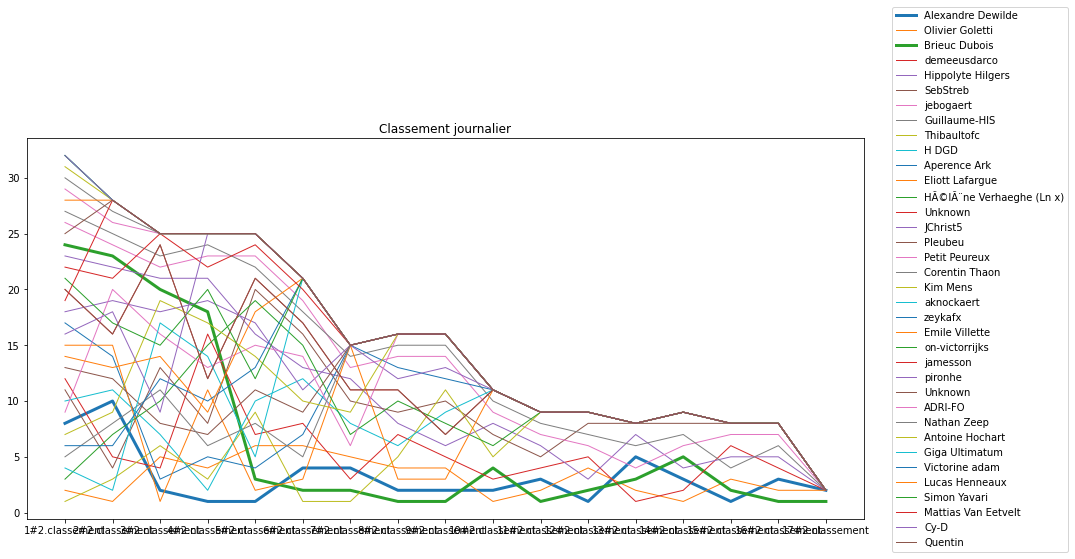

In [11]:
plt.figure(figsize=(15, 7))
plt.title('Classement journalier')
for name, data in df.filter(regex=(r'\d+?#2\.classement')).iterrows():
    if name in watch_list: lw = 3
    else: lw = 1
    plt.plot(data, label=name, linewidth=lw)
_ = plt.legend(bbox_to_anchor=(1.25, -0.1), loc="lower right")

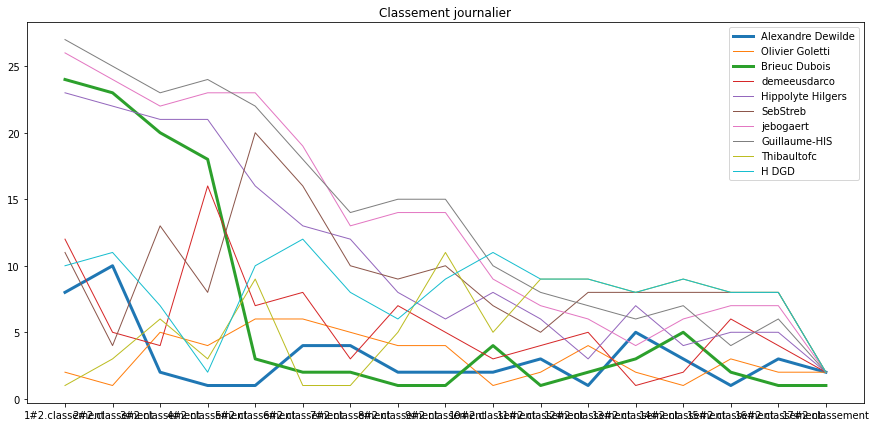

In [12]:
plt.figure(figsize=(15, 7))
plt.title('Classement journalier')
for name, data in df.filter(regex=(r'\d+?#2\.classement')).head(10).iterrows():
    if name in watch_list: lw = 3
    else: lw = 1
    plt.plot(data, label=name, linewidth=lw)
_ = plt.legend()

## Durée entre le premier le second exercice

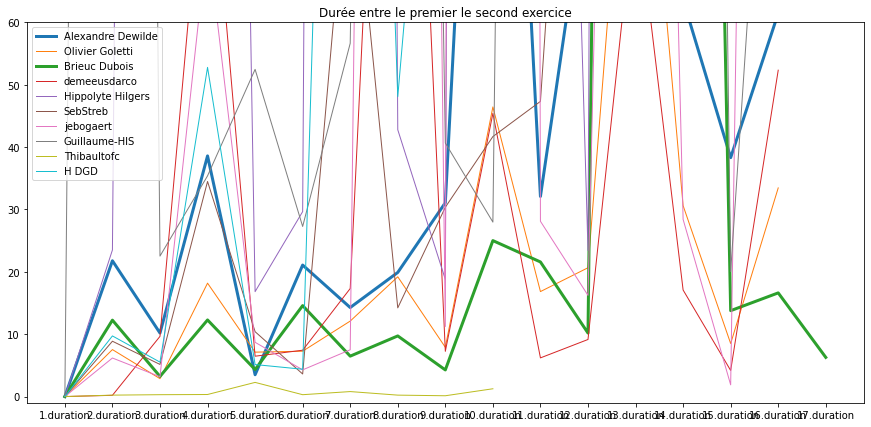

In [13]:
plt.figure(figsize=(15, 7))
plt.title('Durée entre le premier le second exercice')
plt.ylim(-1, 60)
#plt.yscale('log', basey=10)
for name, data in df.filter(regex=(r'\d+?\.duration')).head(10).iterrows():
    if name in watch_list: lw = 3
    else: lw = 1
    plt.plot(data, label=name, linewidth=lw)
_ = plt.legend()

In [14]:
df.loc['Alexandre Dewilde']['16#1']

1608102480

## Évolution du classement

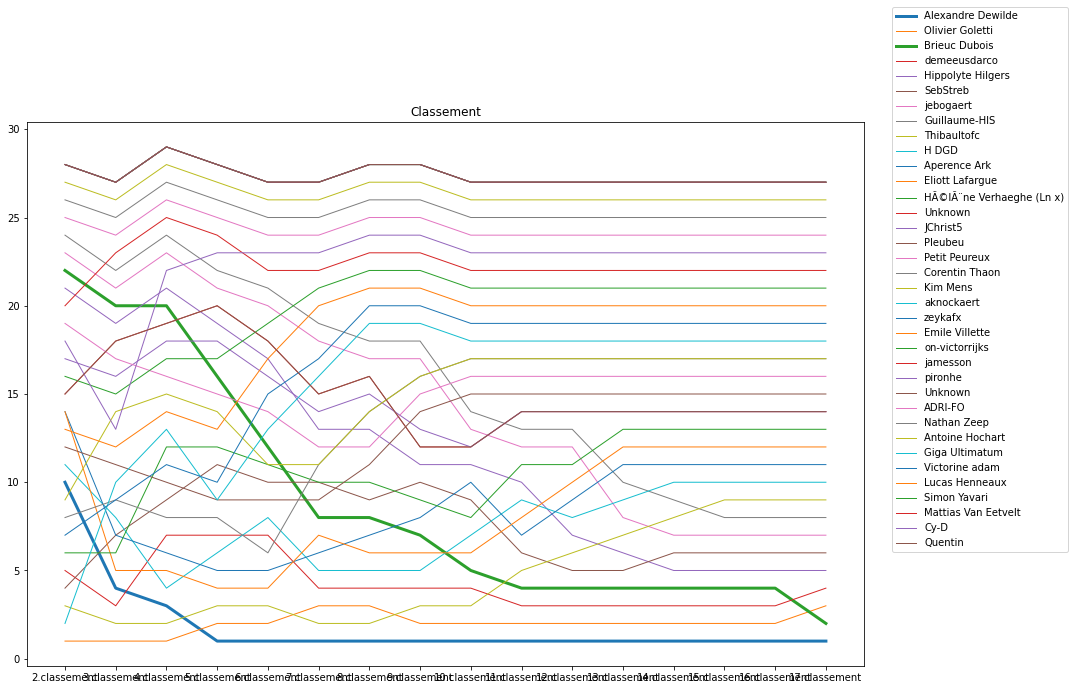

In [15]:
plt.figure(figsize=(15, 10))
plt.title('Classement')
for name, data in df.filter(regex=(r'^\d+?\.classement$')).iterrows():
    if name in watch_list: lw = 3
    else: lw = 1
    plt.plot(data, label=name, linewidth=lw)
_ = plt.legend(bbox_to_anchor=(1.25, 0.2), loc="lower right")

In [16]:
durations = df.filter(regex='\d+?.duration')
del durations['1.duration']
durations = durations.drop('Thibaultofc')
durations['2.duration'].loc['demeeusdarco'] = np.NaN
durations['3.duration'].loc['zeykafx'] = np.NaN

In [17]:
med = durations/durations.median()

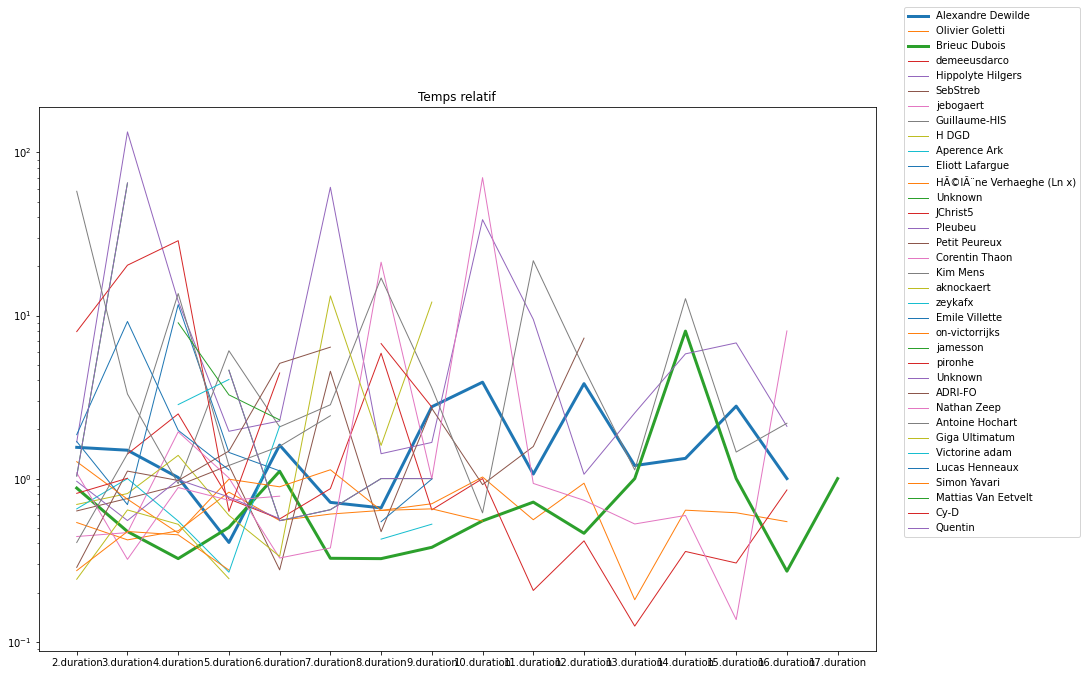

In [18]:
plt.figure(figsize=(15, 10))
plt.title('Temps relatif')
#plt.ylim(-0.5, 4)
plt.yscale('log', basey=10)
for name, data in med.iterrows():
    if name in watch_list: lw = 3
    else: lw = 1
    plt.plot(data, label=name, linewidth=lw)
_ = plt.legend(bbox_to_anchor=(1.25, 0.2), loc="lower right")

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

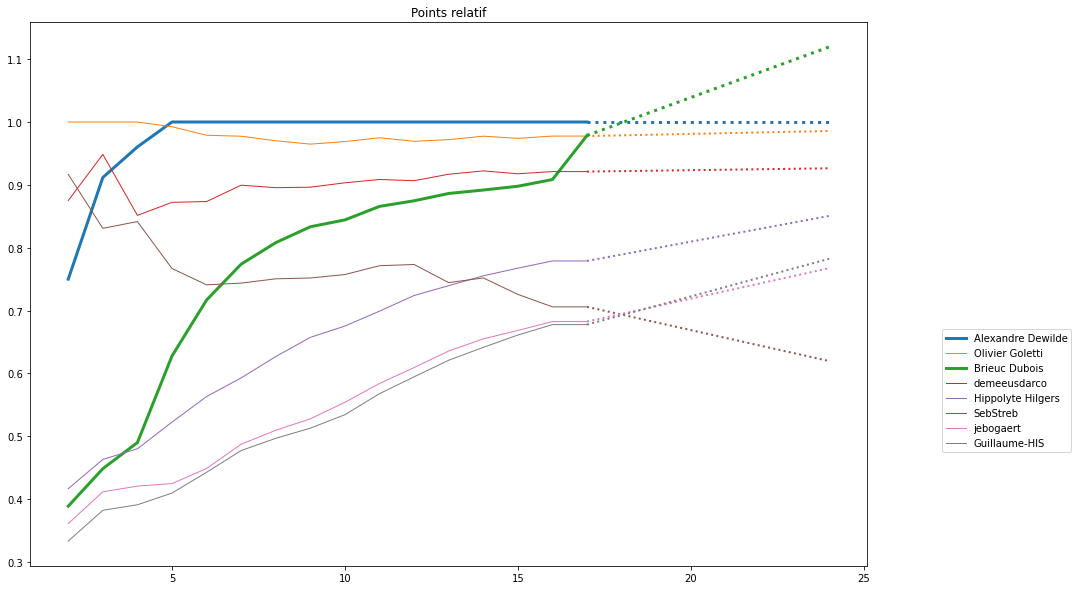

In [29]:
plt.figure(figsize=(15, 10))
plt.title('Points relatif')
#plt.ylim(-0.5, 4)
for i, (name, data) in enumerate(df.filter(regex=(r'^\d+?\.relative\.pts$')).head(8).iterrows()):
    X = [[int(re.search(r'\d+', el).group())] for el in data.keys()]
    y = data.values
    reg=LinearRegression()
    reg.fit(X[-5:], y[-5:])
    
    if name in watch_list: lw = 3
    else: lw = 1
    plt.plot(X, y, label=name, linewidth=lw, color=colors[i%len(colors)])
    m = max(X)[0]
    Xpred = [[x] for x in range(m, 25)]
    ypred = reg.predict(Xpred)
    ypred += y[-1] - ypred[0]
    plt.plot(Xpred, ypred, color=colors[i%len(colors)], linewidth=2 if lw == 1 else lw, linestyle=':')
_ = plt.legend(bbox_to_anchor=(1.25, 0.2), loc="lower right")
# plt.plot([[m], [m]], [0.3, 1], color='#aaaaaa', linestyle='--')

In [18]:
from fractions import Fraction
from matplotlib import pyplot as plt

In [19]:
a, b, c = 9, 4, 6

In [20]:
def suite(frac, n):
    c = 0    while c*frac.numerator <= n:
        yield c*frac.numerator
        c += 1

In [21]:
def m1(n):
    i = 0
    poss = []
    for x in filter(lambda x: not x%Fraction(c,a).numerator, range(n)):
        for y in suite(Fraction(c,b), n):
            i += 1
            z = int((a*x + b*y)/c)
            if z >= n:
                break
            # print(f'x={x} y={y} z={z}')
    return i

In [22]:
def m2(n):
    j = 0
    for x in range(n):
        for y in range(n):
            for z in range(n):
                j+=1
                if a*x + b*y == c*z:
                    pass # print(f'x={x} y={y} z={z}')
    return j

In [23]:
m1m = []
m2m = []
for i in range(100):
    m1m.append(m1(i))
    m2m.append(m2(i))

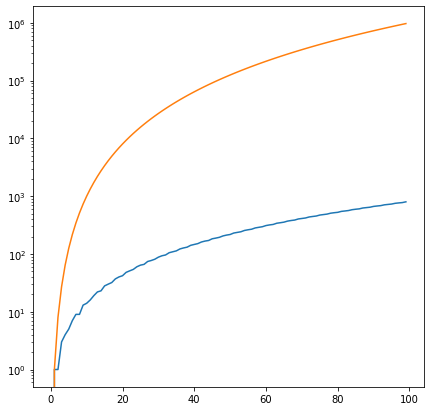

In [24]:
plt.figure(figsize=(7,7))
plt.yscale('log', basey=10)
plt.plot(m1m)
plt.plot(m2m)

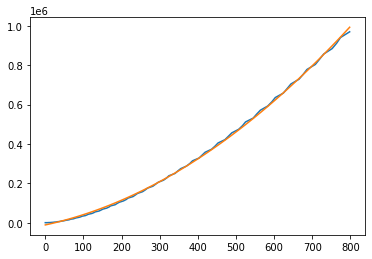

In [25]:
plt.plot(m1m, m2m)
mymodel = np.poly1d(np.polyfit(m1m, m2m, 2))
plt.plot(m1m, mymodel(m1m))

In [26]:
n**2 * 1.055 + n * 417.4 - 11400

NameError: name 'n' is not defined

In [95]:
'ceci est un test de est lol'.partition('est')

('ceci ', 'est', ' un test de est lol')

In [96]:
'ceci est un test de est lol'.split(maxsplit=1)

['ceci', 'est un test de est lol']